This project aims to investigate the effectiveness of the following machine learning (ML) algorithms in predicting fraud in electricity and gas consumption.
* **Logistic Regression** (LR), implemented via scikit-learn
* **Support Vector Machine** (SVM), implemented via scikit-learn
* **Extreme Gradient Boosting** (XGB), implemented via xgboost

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression # LR
from sklearn.svm import SVC # SVM
from xgboost import XGBClassifier # XGB

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, balanced_accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection
from imblearn.combine import SMOTEENN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## **Dataset**

The dataset consists of two files, “client.csv” and “invoice.csv”. 

The former contains 5 features of identifying information for around 11,000 clients, with each client labelled according to their involvement in fraud or lack thereof ('target'). The latter comprises the transaction records of these clients, containing 12 features inclusive of consumption levels, invoice date and tariff type. 

In [ ]:
client = pd.read_csv('../dataset/client.csv')
invoice = pd.read_csv('../dataset/invoice.csv')

In [9]:
client.head()

,region,date,dis,id,catg,target
0,301,13/3/1986,62,10,11,0
1,105,11/7/1996,69,100,11,0
2,303,14/10/2014,62,1000,11,0
3,101,25/10/2011,60,100003,11,0
4,311,30/6/2006,63,100004,12,0


In [10]:
invoice.head()

,id,date,tarif_type,counter_statue,reading_remarque,consommation_level_4,months_number,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3
0,10,15/2/2010,11,0,8,0,4,ELEC,1,407,0,0
1,10,6/3/2015,11,0,8,0,8,ELEC,1,815,0,0
2,10,13/2/2009,11,0,6,0,4,ELEC,1,569,0,0
3,10,2/5/2019,11,0,9,0,12,ELEC,1,2400,682,0
4,10,30/5/2017,11,0,8,0,4,ELEC,1,188,0,0


The two files are merged to form a single unified dataset, with each invoice prepended with its client's details (based on the unique client ID, which is a common feature).

In [11]:
client.rename(columns={'date': 'date_client'}, inplace=True)
invoice.rename(columns={'date': 'date_invoice'}, inplace=True)

df = pd.merge(client, invoice, on='id', how='left')

In [12]:
client_10 = df[df['id'] == 10]
client_10.head()

,region,date_client,dis,id,catg,target,date_invoice,tarif_type,counter_statue,reading_remarque,consommation_level_4,months_number,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3
0,301,13/3/1986,62,10,11,0,15/2/2010,11,0,8,0,4,ELEC,1,407,0,0
1,301,13/3/1986,62,10,11,0,6/3/2015,11,0,8,0,8,ELEC,1,815,0,0
2,301,13/3/1986,62,10,11,0,13/2/2009,11,0,6,0,4,ELEC,1,569,0,0
3,301,13/3/1986,62,10,11,0,2/5/2019,11,0,9,0,12,ELEC,1,2400,682,0
4,301,13/3/1986,62,10,11,0,30/5/2017,11,0,8,0,4,ELEC,1,188,0,0


## **Exploratory Data Analysis (EDA)**



The dataset does not contain any null values.

In [13]:
df.isna().sum() 

region                  0
date_client             0
dis                     0
id                      0
catg                    0
target                  0
date_invoice            0
tarif_type              0
counter_statue          0
reading_remarque        0
consommation_level_4    0
months_number           0
counter_type            0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
dtype: int64

The dataset is highly imbalanced, as only a small minority of clients (4.4%) engage in fraudulent behaviour.

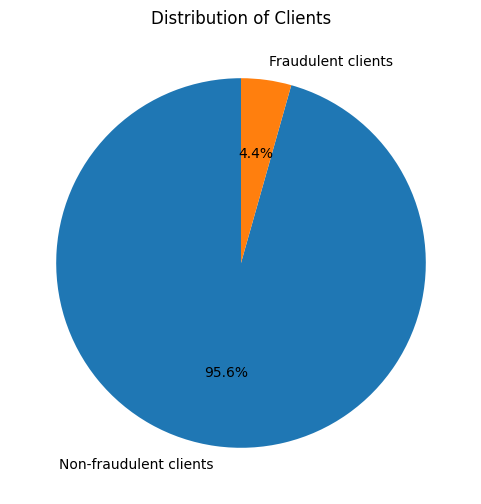

In [14]:
client_0 = df[df['target'] == 0]['id'].nunique() 
client_1 = df[df['target'] == 1]['id'].nunique()

data = [client_0, client_1]
labels = ['Non-fraudulent clients', 'Fraudulent clients']

plt.figure(figsize=(6, 6))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Clients')
plt.show()

Some features contain nominal categorical data, represented by an integer or a string.
* client's `region`, `dis` (district), `catg` (category)
* invoice's `counter_type`

Some features contain discrete numerical data, represented by an integer.
* invoice's `reading_remarque`, `counter_coefficient`

Some features contain dates, represented by a string.
* client's `date_client`
* invoice's `date_invoice`

In [15]:
df.dtypes

region                   int64
date_client             object
dis                      int64
id                       int64
catg                     int64
target                   int64
date_invoice            object
tarif_type               int64
counter_statue           int64
reading_remarque         int64
consommation_level_4     int64
months_number            int64
counter_type            object
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
dtype: object

## **Train-test split**

The dataset is randomly stratified by client ID into training data (80%) and testing data (20%). This ensures that the models will not be trained on any of the testing data, to avoid overfitting.

In [16]:
y = client['target']
X = client['id']

X_train_id, X_test_id, y_train, y_test = \
    train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1)

X_train_merged = pd.merge(X_train_id, df, on = 'id', how = 'inner')
X_test_merged = pd.merge(X_test_id, df, on = 'id', how = 'inner')

X_train = X_train_merged.drop(columns = ['target'])
X_test = X_test_merged.drop(columns = ['target'])

In [17]:
print("\033[4mTraining data\033[0m")
print(X_train.shape)
print(y_train.shape)

print("\n\033[4mTesting data\033[0m")
print(X_test.shape)
print(y_test.shape)

Training data
(155308, 16)
(9392,)

Testing data
(39066, 16)
(2349,)


## **Data pre-processing**

### **Feature engineering**


One-hot encoding (OHE) is used to obtain binary data for features containing categorical data, to avoid algorithmic bias.


In [18]:
def one_hot_encode(df, column_names, drop_original=True, prefix=None):
    for column_name in column_names:
        one_hot = pd.get_dummies(df[column_name], prefix=column_name)
        df = pd.concat([df, one_hot], axis=1)
        if drop_original:
            df.drop(columns=[column_name], inplace=True)
    return df

As each client has multiple invoice records in the merged dataset, data entries are aggregated by client ID to construct new features that provide more information about the client.

In [19]:
def construct_features(df):

    # Group by client ID
    grouped = df.groupby('id')
    one_hot_columns = [col for col in df.columns \
                       if col.startswith(('counter_type', 'dis', 'catg','region'))]
    one_hot_features = grouped[one_hot_columns].first()

    # Aggregate consumption statistics by computing mean, max, min, std
    consumption_columns = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', \
                            'consommation_level_4', 'counter_coefficient', 'reading_remarque']
    consumption_stats = grouped[consumption_columns].agg(['mean', 'max', 'min', 'std'])

    # Aggregate invoice dates by computing mean, max, min duration between successive invoices
    df['date_invoice'] = pd.to_datetime(df['date_invoice'], dayfirst=True) 
    df['duration_succ'] = df.groupby('id')['date_invoice'].diff().dt.days / 30.0  # Decimal months
    duration_succ_stats = grouped['duration_succ'].agg(['mean', 'max', 'min'])

    # Compute the duration between the client joining and the client's most recent invoice
    df['date_client'] = pd.to_datetime(df['date_client'], dayfirst=True)
    df['duration_total'] = (df['date_invoice'] - df['date_client']).dt.days / 30.0 # Decimal months
    duration_total = grouped['duration_total'].max()

    final_features = pd.concat([one_hot_features, consumption_stats, \
                                duration_succ_stats, duration_total], axis=1)
    final_features.columns = ['_'.join(col) if isinstance(col, tuple) else col \
                              for col in final_features.columns]
    return final_features

### **Feature scaling**

Numerical features are standardised to prevent variations in magnitudes from affecting the weightage given to each feature.

In [20]:
def standardise(df, column_name):
  for column in column_name:
    df[column] = (df[column] - df[column].mean()) / df[column].std()
  return df

In [21]:
# Perform feature engineering and feature scaling on train set
columns_to_encode = ['counter_type', 'dis', 'catg','region']
standardised_column = ['consommation_level_1_mean',
       'consommation_level_1_max', 'consommation_level_1_min',
       'consommation_level_1_std', 'consommation_level_2_mean',
       'consommation_level_2_max', 'consommation_level_2_min',
       'consommation_level_2_std', 'consommation_level_3_mean',
       'consommation_level_3_max', 'consommation_level_3_min',
       'consommation_level_3_std', 'consommation_level_4_mean',
       'consommation_level_4_max', 'consommation_level_4_min',
       'consommation_level_4_std', 'counter_coefficient_mean',
       'counter_coefficient_max', 'counter_coefficient_min',
       'counter_coefficient_std', 'reading_remarque_mean',
       'reading_remarque_max', 'reading_remarque_min', 'reading_remarque_std',
       'mean', 'max', 'min', 'duration_total']

X_train_2 = one_hot_encode(X_train, columns_to_encode, drop_original=True, prefix=None)
X_train_2 = construct_features(X_train_2)
X_train_2 = standardise(X_train_2, standardised_column)

In [22]:
print(X_train.shape)
print(X_train_2.shape)

(155308, 16)
(9392, 61)


### **Feature selection**

There is a large number of features (60, excluding client ID) in the dataset after feature engineering.

It is therefore necessary to perform feature selection to reduce computational load and reduce overfitting. By prioritising features with the best cross-validation scores, Sequential Forward Selection (SFS) is used to investigate the relationship between the number of features and the ROC-AUC Score of the model.

In [23]:
num_cols = X_train_2.shape[1]

sfs = SequentialFeatureSelector(
    estimator = LogisticRegression(random_state = 2), 
    k_features = (1, num_cols), 
    scoring = 'roc_auc', 
    cv = 5
)

sfs.fit(X_train_2, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=2),
                          k_features=(1, 61), scoring='roc_auc')

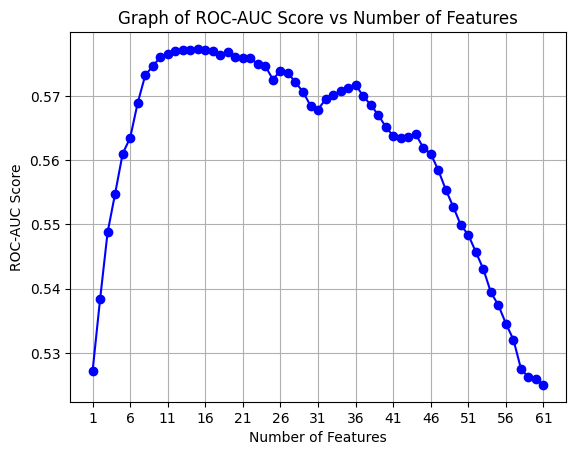

In [24]:
sfs_graph = plot_sequential_feature_selection(sfs.get_metric_dict(), kind = None)
plt.title('Graph of ROC-AUC Score vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC Score')
plt.xticks(ticks = range(1, num_cols + 1, 5),)
plt.grid()
plt.show()

From the graph above, the elbow method is used to determine the optimal number of features (11). SFS is used to select the 11 most relevant features from the dataset.

In [25]:
sfs = SequentialFeatureSelector( 
    estimator = LogisticRegression(random_state = 12), 
    k_features = 11, 
    scoring = 'roc_auc'
)

sfs.fit(X_train_2, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=12),
                          k_features=(11, 11), scoring='roc_auc')

In [26]:
features_selected = list(sfs.k_feature_names_)
X_train_3 = X_train_2[features_selected]

In [27]:
print(features_selected)
print(X_train_3.shape)

['counter_type_ELEC', 'counter_type_GAZ', 'region_103', 'region_302', 'region_304', 'region_305', 'region_308', 'region_311', 'region_371', 'consommation_level_1_min', 'consommation_level_2_std']
(9392, 11)


### **Oversampling**

To address class imbalance in the dataset, the Synthetic Minority Oversampling Technique (SMOTE) is used to over-sample the minority class (i.e. fraudulent clients) by synthetically generating new data points.

In [28]:
smote = SMOTEENN(random_state=1)
X_train_res, y_train_res = smote.fit_resample(X_train_3, y_train)

In [29]:
print(f"\033[4mInitial distribution\033[0m\n{y_train.value_counts()}")
print(f"\n\033[4mAfter SMOTE\033[0m\n{y_train_res.value_counts()}")

Initial distribution
target
0    8980
1     412
Name: count, dtype: int64

After SMOTE
target
0    6039
1    3606
Name: count, dtype: int64


In [30]:
columns_to_encode = ['counter_type', 'dis', 'catg','region']
X_test_2 = one_hot_encode(X_test, columns_to_encode, drop_original=True, prefix=None)
X_test_2 = construct_features(X_test_2)
X_test_2 = standardise(X_test_2, standardised_column)

X_test_res = X_test_2[features_selected]
y_test_res = y_test

In [31]:
print(X_train_res.shape)
print(y_train_res.shape)
print(X_test_res.shape)
print(y_test_res.shape)

(9645, 11)
(9645,)
(2349, 11)
(2349,)


## **Results of vanilla models**

The three ML algorithms are each trained on the training data, with 5-fold cross-validation (5-CV) used to estimate model performance within the training environment. Subsequently, the models' predictive and generalisation abilities are validated on the testing data.

It can be seen from the results that the vanilla models have significantly lower precision and recall for fraudulent clients (`target`=1) when tested on the holdout data that was portioned from the initial dataset, as compared to the cross-validated metrics. This suggests that the model overfits to the training data.

One possible explanation could be insufficient or improper handling of class imbalance. Although SMOTE was performed to oversample the minority data, the synthetic samples it generated might not be representative of the complexity of actual fraudulent samples.

Of the three vanilla models, SVM has the highest target recall of 0.23.

### **Logistic Regression (LR)**

In [32]:
lr = LogisticRegression(random_state=1)

# Train on training data
y_train_pred = cross_val_predict(lr, X_train_res, y_train_res, cv=5)
roc_auc_score = cross_val_score(lr, X_train_res, y_train_res, cv=5, scoring='roc_auc')
lr.fit(X_train_res, y_train_res)

# Test on testing data
y_test_pred = lr.predict(X_test_res)
balanced_acc_score = balanced_accuracy_score(y_test_res, y_test_pred)

In [33]:
print(f"\033[4mCross-validated metrics (training data)\033[0m\n{classification_report(y_train_res, y_train_pred)}")
print(f"Mean ROC-AUC Score: {roc_auc_score.mean():.4f}\n")
print(f"\033[4mEvaluation metrics (testing data)\033[0m\n{classification_report(y_test_res, y_test_pred)}")
print(f"Balanced accuracy score: {balanced_acc_score:.4f}")

Cross-validated metrics (training data)
              precision    recall  f1-score   support

           0       0.68      0.90      0.77      6039
           1       0.63      0.28      0.39      3606

    accuracy                           0.67      9645
   macro avg       0.65      0.59      0.58      9645
weighted avg       0.66      0.67      0.63      9645

Mean ROC-AUC Score: 0.6826

Evaluation metrics (testing data)
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2246
           1       0.06      0.18      0.09       103

    accuracy                           0.84      2349
   macro avg       0.51      0.53      0.50      2349
weighted avg       0.92      0.84      0.88      2349

Balanced accuracy score: 0.5288


### **Support Vector Machine (SVM)**

In [34]:
svm = SVC(random_state=1)

# Train on training data
y_train_pred = cross_val_predict(svm, X_train_res, y_train_res, cv=5)
roc_auc_score = cross_val_score(svm, X_train_res, y_train_res, cv=5, scoring='roc_auc')
svm.fit(X_train_res, y_train_res)

# Test on testing data
y_test_pred = svm.predict(X_test_res)
balanced_acc_score = balanced_accuracy_score(y_test_res, y_test_pred)

In [35]:
print(f"\033[4mCross-validated metrics (training data)\033[0m\n{classification_report(y_train_res, y_train_pred)}")
print(f"Mean ROC-AUC Score: {roc_auc_score.mean():.4f}\n")
print(f"\033[4mEvaluation metrics (testing data)\033[0m\n{classification_report(y_test_res, y_test_pred)}")
print(f"Balanced accuracy score: {balanced_acc_score:.4f}")

Cross-validated metrics (training data)
              precision    recall  f1-score   support

           0       0.69      0.91      0.79      6039
           1       0.69      0.32      0.44      3606

    accuracy                           0.69      9645
   macro avg       0.69      0.62      0.61      9645
weighted avg       0.69      0.69      0.66      9645

Mean ROC-AUC Score: 0.7496

Evaluation metrics (testing data)
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      2246
           1       0.06      0.23      0.10       103

    accuracy                           0.82      2349
   macro avg       0.51      0.54      0.50      2349
weighted avg       0.92      0.82      0.86      2349

Balanced accuracy score: 0.5377


### **Extreme Gradient Boosting (XGB)**

In [36]:
xgb = XGBClassifier(random_state=1, objective='binary:logistic')

# Train on training data
y_train_pred = cross_val_predict(xgb, X_train_res, y_train_res, cv=5)
roc_auc_score = cross_val_score(xgb, X_train_res, y_train_res, cv=5, scoring='roc_auc')
xgb.fit(X_train_res, y_train_res)

# Test on testing data
y_test_pred = xgb.predict(X_test_res)
balanced_acc_score = balanced_accuracy_score(y_test_res, y_test_pred)

In [37]:
print(f"\033[4mCross-validated metrics (training data)\033[0m\n{classification_report(y_train_res, y_train_pred)}")
print(f"Mean ROC-AUC Score: {roc_auc_score.mean():.4f}\n")
print(f"\033[4mEvaluation metrics (testing data)\033[0m\n{classification_report(y_test_res, y_test_pred)}")
print(f"Balanced accuracy score: {balanced_acc_score:.4f}")

Cross-validated metrics (training data)
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      6039
           1       0.92      0.91      0.91      3606

    accuracy                           0.94      9645
   macro avg       0.93      0.93      0.93      9645
weighted avg       0.94      0.94      0.94      9645

Mean ROC-AUC Score: 0.9781

Evaluation metrics (testing data)
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2246
           1       0.04      0.13      0.06       103

    accuracy                           0.82      2349
   macro avg       0.50      0.49      0.48      2349
weighted avg       0.91      0.82      0.86      2349

Balanced accuracy score: 0.4890


## **Hyperparameter tuning**

To improve model performance, random search is used to optimise the set of hyperparameters by sampling random combinations of parameter values. This is preferred over grid search due to its lower computational cost, particularly when working with large datasets.

It can be seen from the results that target recall has improved across all three models. However, the improvement in target recall for SVM has come at the cost of the recall for the negative class (`target`=0). The combination of precision and recall scores for the target and negative classes suggest that the hyperparameter-tuned SVM model acts almost as a naive classifier.

Of the other two models, the hyperparameter-tuned LR model has the better target recall of 0.42.

Nevertheless, target precision remains low. This poses a problem as it necessitates a large number of in-person field inspections to verify all cases of suspected fraudulent activity. Financial means may limit the number of such inspections that can be feasibly carried out.

### **LR (Hyperparameter-tuned)**

In [38]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(solver="saga", max_iter=5000, random_state=1))
    ]
)

param_distributions = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__class_weight': [{0: 1, 1: i} for i in range(1, 11)] + ['balanced']
}

randomized_search = RandomizedSearchCV( 
    estimator=pipeline, 
    param_distributions=param_distributions, 
    n_iter=30, 
    cv=5, 
    scoring='f1',
    random_state=1,
    verbose=1
)

randomized_search.fit(X_train_res, y_train_res)
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_

# Repeat testing with optimised hyperparameters
lr_best = randomized_search.best_estimator_
y_pred_best = lr_best.predict(X_test_res)
balanced_acc_score = balanced_accuracy_score(y_test_res, y_pred_best)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [39]:
print(f"\033[4mHyperparameters selected\033[0m\n{best_params}\nWith mean cross-validated score of {best_score:.4f}")
print(f"\n\033[4mEvaluation metrics (testing data)\033[0m\n{classification_report(y_test_res, y_pred_best)}")
print(f"Balanced accuracy score: {balanced_acc_score:.4f}")

Hyperparameters selected
{'clf__penalty': 'l1', 'clf__class_weight': {0: 1, 1: 2}, 'clf__C': 0.01}
With mean cross-validated score of 0.5742

Evaluation metrics (testing data)
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      2246
           1       0.05      0.42      0.08       103

    accuracy                           0.60      2349
   macro avg       0.50      0.52      0.42      2349
weighted avg       0.92      0.60      0.72      2349

Balanced accuracy score: 0.5155


### **SVM (Hyperparameter-tuned)**

In [40]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", SVC(random_state=1, max_iter=-1))
    ]
)

param_distributions = [
    # Linear kernel
    {
        "clf__kernel": ["linear"],
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__class_weight": [{0: 1, 1: i} for i in range(1, 11)] + ["balanced"]
    },

    # RBF kernel
    {
        "clf__kernel": ["rbf"],
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__gamma": ["scale", 0.01, 0.05],
        "clf__class_weight": [{0: 1, 1: i} for i in range(1, 11)] + ["balanced"]
    }
]

randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=15,
    cv=5,
    scoring='f1',
    random_state=1,
    verbose=1,
    n_jobs=-1
)

randomized_search.fit(X_train_res, y_train_res)
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_

# Repeat testing with optimised hyperparameters
svm_best = randomized_search.best_estimator_
y_pred_best = svm_best.predict(X_test_res)
balanced_acc_score = balanced_accuracy_score(y_test_res, y_pred_best)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [41]:
print(f"\033[4mHyperparameters selected\033[0m\n{best_params}\nWith mean cross-validated score of {best_score:.4f}")
print(f"\n\033[4mEvaluation metrics (testing data)\033[0m\n{classification_report(y_test_res, y_pred_best)}")
print(f"Balanced accuracy score: {balanced_acc_score:.4f}")

Hyperparameters selected
{'clf__kernel': 'rbf', 'clf__gamma': 0.05, 'clf__class_weight': {0: 1, 1: 7}, 'clf__C': 10}
With mean cross-validated score of 0.5621

Evaluation metrics (testing data)
              precision    recall  f1-score   support

           0       0.97      0.09      0.16      2246
           1       0.04      0.93      0.09       103

    accuracy                           0.12      2349
   macro avg       0.51      0.51      0.12      2349
weighted avg       0.92      0.12      0.16      2349

Balanced accuracy score: 0.5094


### **XGB (Hyperparameter-tuned)**

In [42]:
param_distributions = {
    'learning_rate': [0.001, 0.01, 0.1, 1, 10],
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'gamma': [0, 0.01, 0.1],
    'colsample_bytree': [0.5, 0.75, 1]
}

randomized_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=1, objective='binary:logistic'),
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    scoring='f1',
    verbose=1
)

randomized_search.fit(X_train_res, y_train_res)
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_

# Repeat testing with optimised hyperparameters
xgb_best = randomized_search.best_estimator_
y_pred_best = xgb_best.predict(X_test_res)
balanced_acc_score = balanced_accuracy_score(y_test_res, y_pred_best)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [43]:
print(f"\033[4mHyperparameters selected\033[0m\n{best_params}\nWith mean cross-validated score of {best_score:.4f}")
print(f"\n\033[4mEvaluation metrics (testing data)\033[0m\n{classification_report(y_test_res, y_pred_best)}")
print(f"Balanced accuracy score: {balanced_acc_score:.4f}")

Hyperparameters selected
{'subsample': 0.5, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1}
With mean cross-validated score of 0.9256

Evaluation metrics (testing data)
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      2246
           1       0.05      0.17      0.07       103

    accuracy                           0.81      2349
   macro avg       0.50      0.51      0.48      2349
weighted avg       0.92      0.81      0.86      2349

Balanced accuracy score: 0.5050


More details can be found in `../report.pdf`. 